In [133]:
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from statsmodels.tsa.api import VAR
from tqdm.auto import tqdm

# Load Data

In [27]:
dt = 0.01

In [103]:
eeg = mne.io.read_raw_edf("/om/user/eisenaj/datasets/sleep/SC4001E0-PSG.edf")
eeg_df = eeg.to_data_frame()
hypnogram = mne.read_annotations("/om/user/eisenaj/datasets/sleep/SC4001EC-Hypnogram.edf")
hypnogram_df = hypnogram.to_data_frame()

Extracting EDF parameters from /om/user/eisenaj/datasets/sleep/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [121]:
eeg_df['sleep_stage'] = [None]*len(eeg_df)
place_in_session = 0
for i, row in tqdm(hypnogram_df.iterrows(), total=len(hypnogram_df)):
    if i == 0:
        indices = eeg_df.time <= place_in_session + int(row.duration/0.001)
    else:
        indices = np.logical_and(eeg_df.time > place_in_session, eeg_df.time <= place_in_session + int(row.duration/0.001))
    eeg_df.loc[indices, 'sleep_stage'] = row.description[-1]
    place_in_session += int(row.duration/0.001)

  0%|          | 0/154 [00:00<?, ?it/s]

## Plot

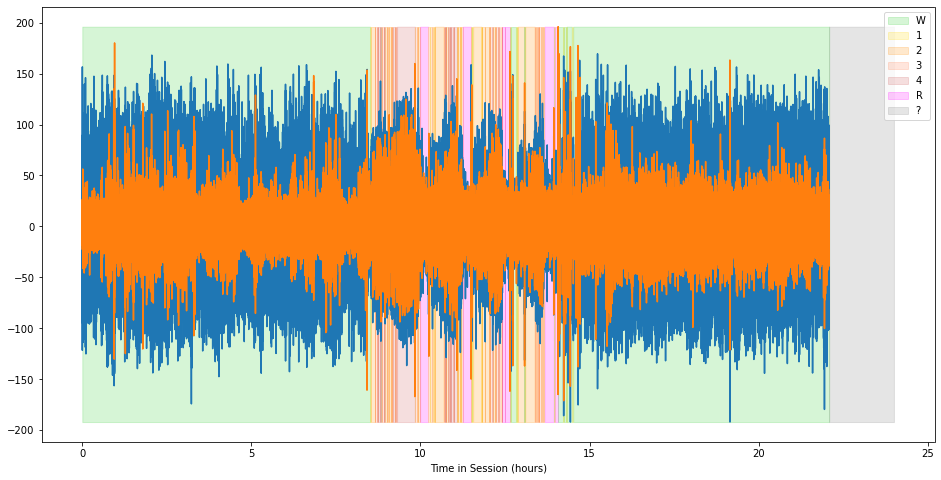

In [73]:
colors = {'W': 'limegreen', '1': 'gold', '2': 'darkorange', '3': 'coral', '4': 'indianred', 'R': 'magenta', '?': 'gray'}

plt.figure(figsize=(16, 8))
time_vals = eeg_df.time*0.001/3600
plt.plot(time_vals, eeg_df['EEG Fpz-Cz'])
plt.plot(time_vals, eeg_df['EEG Pz-Oz'])
min_val = np.min([eeg_df['EEG Fpz-Cz'].min(), eeg_df['EEG Pz-Oz'].min()])
max_val = np.maxfrom statsmodels.tsa import stattools([eeg_df['EEG Fpz-Cz'].max(), eeg_df['EEG Pz-Oz'].max()])
place_in_session = 0

seen = {}
for stage in colors.keys():
    seen[stage] = False
for _, row in hypnogram_df.iterrows():
#     print(row.description[-1], colors[row.description[-1]])
    plt.fill_between(np.arange(place_in_session, place_in_session + row.duration)/3600, min_val, max_val, color=colors[row.description[-1]], label=row.description[-1] if not seen[row.description[-1]] else "", alpha=0.2)
    place_in_session += row.duration
    seen[row.description[-1]] = True
#     print(place_in_session)
plt.xlabel("Time in Session (hours)")
# plt.xlim([8.5, 9])
plt.legend()
plt.show()

## VAR

In [124]:
def compute_VAR(window_data, unit_indices=None, PCA_dim=-1):
    if unit_indices is None:
        chunk = window_data
    else:
        chunk = window_data[:, unit_indices]
    k = chunk.shape[0]

    results = {}
    results['explained_variance'] = None
    if PCA_dim > 0:
        if PCA_dim < 2:
            raise ValueError(f"PCA dimension must be greater than 1; provided value was {PCA_dim}")
        pca = PCA(n_components=PCA_dim)
        chunk = pca.fit_transform(chunk)
        results['explained_variance'] = pca.explained_variance_ratio_
    
    model = VAR(chunk)
    VAR_results = model.fit(1)
    results['A_mat'] = VAR_results.coefs[0]
    results['A_mat_with_bias'] = VAR_results.params
    e,_ = np.linalg.eig(VAR_results.coefs[0])   
    results['eigs'] = e   
    results['criticality_inds'] = np.abs(e)

    results['sigma2_ML'] = np.linalg.norm(VAR_results.endog[1:] - (VAR_results.endog_lagged @ VAR_results.params), axis=1).sum()/(k - 2)
    results['AIC'] = k*np.log(results['sigma2_ML']) + 2
    results['sigma_norm'] = np.linalg.norm(VAR_results.sigma_u, ord=2)

    return results

In [125]:
all_eeg = np.zeros((len(eeg_df), 2))
all_eeg[:, 0] = eeg_df['EEG Fpz-Cz']
all_eeg[:, 1] = eeg_df['EEG Pz-Oz']

In [138]:
window = 10 # seconds
stride = window

num_windows = int(np.floor((all_eeg.shape[0]-int(window/dt))/int(stride/dt))+1)

all_results = []
for i in tqdm(range(num_windows)):
    start_ind = int(i*stride/dt)
    end_ind = int((i*stride + window)/dt)
    window_data = all_eeg[start_ind:end_ind]
    
    results = compute_VAR(window_data)
    results['start_time'] = i*stride
    results['start_time_ms'] = i*stride*1000
    results['start_ind'] = start_ind
    results['end_time'] = i*stride + window
    results['end_time_ms'] = (i*stride + window)*1000
    results['end_ind'] = end_ind
    all_results.append(results)
VAR_results = pd.DataFrame(all_results)

  0%|          | 0/7950 [00:00<?, ?it/s]

## Plot VAR

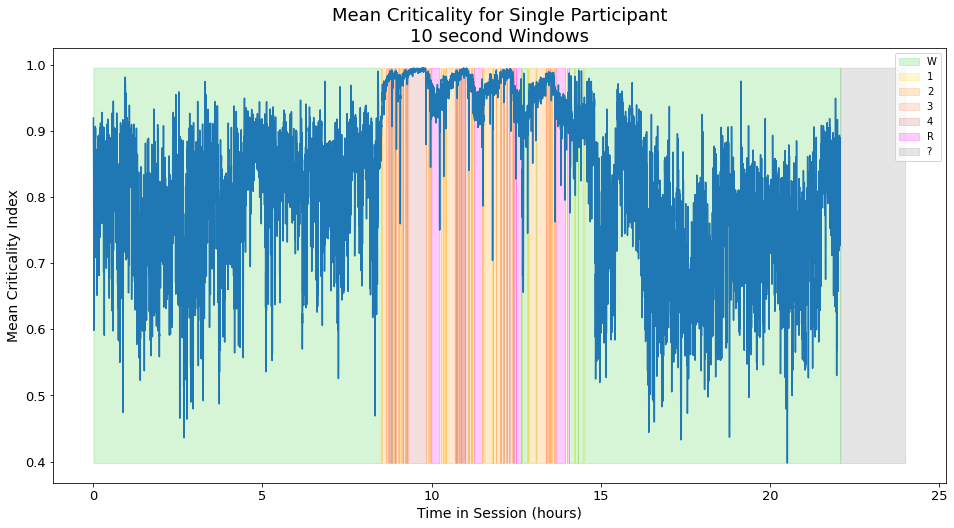

In [202]:
colors = {'W': 'limegreen', '1': 'gold', '2': 'darkorange', '3': 'coral', '4': 'indianred', 'R': 'magenta', '?': 'gray'}

plt.figure(figsize=(16, 8))
time_vals = VAR_results.start_time/3600
# plt.plot(time_vals, eeg_df['EEG Fpz-Cz'])
# plt.plot(time_vals, eeg_df['EEG Pz-Oz'])
criticality_inds = VAR_results.criticality_inds.apply(lambda x: x.mean())
plt.plot(time_vals, criticality_inds)
min_val = criticality_inds.min()
max_val = criticality_inds.max()
place_in_session = 0

seen = {}
for stage in colors.keys():
    seen[stage] = False
for _, row in hypnogram_df.iterrows():
#     print(row.description[-1], colors[row.description[-1]])
    plt.fill_between(np.arange(place_in_session, place_in_session + row.duration)/3600, min_val, max_val, color=colors[row.description[-1]], label=row.description[-1] if not seen[row.description[-1]] else "", alpha=0.2)
    place_in_session += row.duration
    seen[row.description[-1]] = True
#     print(place_in_session)
plt.xlabel("Time in Session (hours)", fontsize=14)
plt.ylabel("Mean Criticality Index", fontsize=14)
plt.tick_params(labelsize=13)
plt.title(f"Mean Criticality for Single Participant\n{window} second Windows", fontsize=18)
# plt.xlim([9, 10])
plt.legend()
plt.show()

## Label VAR Results

In [180]:
VAR_results['sleep_stage'] = [None]*len(VAR_results)
for i, row in tqdm(VAR_results.iterrows(), total=len(VAR_results)):
    stages, counts = np.unique(eeg_df[np.logical_and(eeg_df.time >= row.start_time_ms, eeg_df.time < row.end_time_ms)].sleep_stage, return_counts=True)
    VAR_results.loc[i, 'sleep_stage'] = stages[np.argmax(counts)]

  0%|          | 0/7950 [00:00<?, ?it/s]

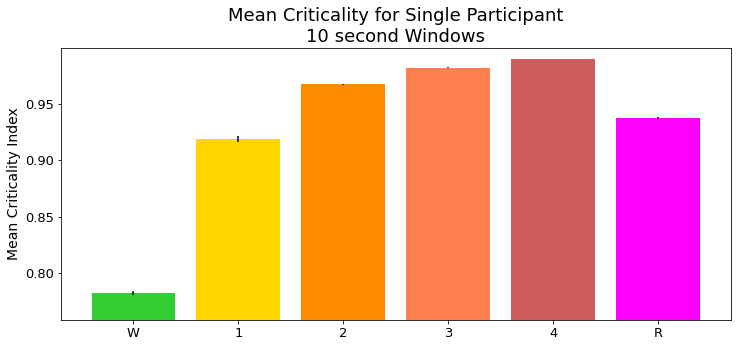

In [203]:
plt.figure(figsize=(12, 5))
mean_criticality_sleep_stage = []
std_error_sleep_stage = []
sleep_stage = []
sleep_stage_colors = []
for s in colors.keys():
    if s != '?':
        sleep_stage.append(s)
        all_inds = np.vstack(VAR_results[VAR_results.sleep_stage == s].criticality_inds.to_numpy()).flatten()
        mean_criticality_sleep_stage.append(all_inds.mean())
        std_error_sleep_stage.append(all_inds.std()/np.sqrt(len(all_inds)))
        sleep_stage_colors.append(colors[s])

plt.bar(sleep_stage, mean_criticality_sleep_stage, yerr=std_error_sleep_stage, color=sleep_stage_colors)
plt.ylim([np.min(mean_criticality_sleep_stage)*0.97, np.max(mean_criticality_sleep_stage)*1.01])
plt.ylabel("Mean Criticality Index", fontsize=14)
plt.tick_params(labelsize=13)
plt.title(f"Mean Criticality for Single Participant\n{window} second Windows", fontsize=18)
plt.show()